In [1]:
# 推理测试
MODEL_PATH = '/data/nvme1/weights/gpu_SFT_Qwen2_5-VL-3B-Instruct_vqa'

from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor, Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL_PATH, torch_dtype="auto", device_map="auto"
)
model

[2025-05-09 17:11:30,770] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/finetune/miniconda3/envs/qwenvl/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/finetune/miniconda3/envs/qwenvl/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlvsym'
/home/finetune/miniconda3/envs/qwenvl/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlopen'
/home/finetune/miniconda3/envs/qwenvl/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlclose'
/home/finetune/miniconda3/envs/qwenvl/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlerror'
/home/finetune/miniconda3/envs/qwenvl/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlsym'
collect2: error: ld returned 1 exit status


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen2_5_VLForConditionalGeneration(
  (visual): Qwen2_5_VisionTransformerPretrainedModel(
    (patch_embed): Qwen2_5_VisionPatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2_5_VLVisionBlock(
        (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
        (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
        (attn): Qwen2_5_VLVisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): Qwen2_5_VLMLP(
          (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
          (act_fn): SiLU()
        )
      )
    )
    (merger): Qwen2_5_VLPatchMerger

# Qwen2.5-VL目标检测任务推理测试

In [2]:
# 推理测试
TRAIN_MODEL_PATH = '/home/lixinyu/weights/gpu_SFT_Qwen2_5-VL-3B-Instruct_vqa'
MODEL_PATH = '/home/lixinyu/weights/Qwen2.5-VL-3B-Instruct'

from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor, Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    TRAIN_MODEL_PATH, torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained(MODEL_PATH)

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "./data/test/003003.jpg",
            },
            {"type": "text", "text": "Please enclose the corresponding positions using coordinate boxes. Examples of coordinate value formats: [x1,y1,x2,y2]. what numbered album is the photo from?"},
        ],
    }
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


['{"bbox_2d": [960, 738, 45, 19]}']


In [3]:
output=output_text[0]

import json

# 去掉多余的格式化字符
# 去掉开头和结尾的 ```json 和换行符
cleaned_string = output.strip("```json\n").strip()

# 将清理后的字符串解析为 Python 字典
data_dict = json.loads(cleaned_string)

# 打印结果
print(data_dict)

{'bbox_2d': [960, 738, 45, 19]}


In [11]:
bbox = data_dict['bbox_2d']
bbox

[960, 738, 45, 19]

In [4]:
data = data_dict[0]
bbox=data['bbox_2d']
bbox

KeyError: 0

In [13]:
import cv2
import numpy as np
import requests
from io import BytesIO

# 图片链接
image_url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
# 图片地址
image_path = "./data/test/003003.jpg"


# 下载图片
response = requests.get(image_url)
if response.status_code == 200:
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
else:
    print("无法下载图片，请检查链接是否有效。")
    exit()

# 加载本地图像
image = cv2.imread(image_path)
print(image.shape)
if image is None:
    print(f"无法加载图像，请检查路径是否正确：{image_path}")
    exit()

# 绘制边界框
cv2.rectangle(image, (bbox[1], bbox[0]), (bbox[1]+bbox[3], bbox[0]+bbox[2]), (0, 0, 255), 3)

# 保存到本地
output_path = "/home/lixinyu/data/pictures/output_image_with_bbox.jpg"
cv2.imwrite(output_path, image)

print(f"图片已保存到本地：{output_path}")

(677, 1024, 3)
图片已保存到本地：/home/lixinyu/data/pictures/output_image_with_bbox.jpg


# 训练相关

In [25]:
# 1、先试试下载的数据集是什么样子
from modelscope.msdatasets import MsDataset
from datasets import load_dataset

DATA_PATH = '/data/nvme0/textvqa_bbox'
ds = load_dataset(DATA_PATH,split='train')
print("-"*20)
print(type(ds[0]['bbox']))
print("-"*20)

# 2、然后对数据集进行改造，数据集保存成jsonl格式

--------------------
<class 'list'>
--------------------


In [2]:
# 1、先试试下载的数据集是什么样子
from datasets import load_dataset

DATA_PATH = '/data/nvme0/AI-ModelScope/the_cauldron'
ds = load_dataset(DATA_PATH,"docvqa")
print("-"*20)
print(ds['train'][0])
print("-"*20)

# 2、然后对数据集进行改造，数据集保存成jsonl格式

Generating train split:   0%|          | 0/10189 [00:00<?, ? examples/s]

--------------------
{'images': [<PIL.PngImagePlugin.PngImageFile image mode=L size=1695x2025 at 0x7F6E34EC0AC0>], 'texts': [{'user': 'What is the date mentioned in this letter?\nOffer a terse response.', 'assistant': '1/8/93.', 'source': 'docvqa'}, {'user': 'What is the contact person name mentioned in letter?\nOffer a terse response.', 'assistant': 'P. carter.', 'source': 'docvqa'}]}
--------------------


In [26]:
import json

# 原始列表
bbox_list = [135, 114, 1016, 672]

# 创建字典
bbox_dict = {"bbox_2d": bbox_list}

# 转换为格式化的 JSON 字符串
formatted_json = json.dumps(bbox_dict, indent=2)

print(formatted_json)

{
  "bbox_2d": [
    135,
    114,
    1016,
    672
  ]
}


In [9]:
from PIL import Image

# 图像路径
image_path = "./examples/test5.jpg"

# 使用Pillow读取图像
try:
    image = Image.open(image_path)
    print(f"Image loaded successfully: {image}")
except FileNotFoundError:
    print(f"Cannot read image: {image_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Image loaded successfully: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x681 at 0x7F6D0D1C13F0>


height and width is: (681, 1024)


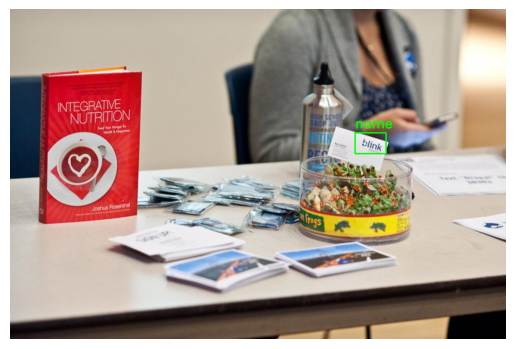

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

bboxes = [
    {"bbox_2d": [712, 255, 776, 298], "label": "name"},
]
image_path = "./pictures/test5.jpg"
image = cv2.imread(image_path)

if image is None:
    print(f"cannot read image: {image_path}")
else:
    h, w = image.shape[:2]
    print(f'height and width is: {h, w}')
    for bbox_info in bboxes:
        bbox = bbox_info["bbox_2d"]
        label = bbox_info["label"]
        x1, y1, x2, y2 = bbox
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

height and width is: (681, 1024)


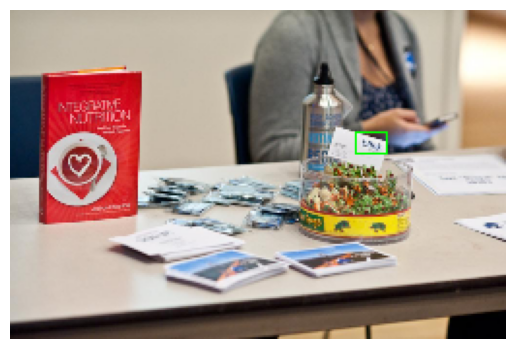

In [11]:
import cv2
import matplotlib.pyplot as plt

def resize_with_max_side(image, max_img_side_length):
    height, width = image.shape[:2]  # 获取原始尺寸
    scale = max_img_side_length / max(width, height)  # 计算缩放比例
    new_width, new_height = int(width * scale), int(height * scale)  # 计算新的尺寸
    return cv2.resize(image, (new_width, new_height)), scale  # 调整大小并返回缩放比例

def resize_bbox(bbox, scale):
    # 缩放矩形框坐标
    return [int(coord * scale) for coord in bbox]

# 图像路径和矩形框信息
image_path = "./examples/test5.jpg"
bboxes = [
    {"bbox_2d": [712, 255, 776, 298], "label": "Object1"}
]

# 加载图像
image = cv2.imread(image_path)

if image is None:
    print(f"cannot read image: {image_path}")
else:
    h, w = image.shape[:2]
    print(f'height and width is: {h, w}')
    
    # 目标最大边长
    max_img_side_length = 256  # 示例最大边长
    
    # 缩放图像和矩形框
    resized_image, scale = resize_with_max_side(image, max_img_side_length)
    resized_bboxes = [{"bbox_2d": resize_bbox(bbox_info["bbox_2d"], scale), "label": bbox_info["label"]} for bbox_info in bboxes]
    
    # 绘制矩形框和标签
    for bbox_info in resized_bboxes:
        bbox = bbox_info["bbox_2d"]
        label = bbox_info["label"]
        x1, y1, x2, y2 = bbox
        cv2.rectangle(resized_image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    # 转换为RGB格式以便使用matplotlib显示
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    
    # 显示图像
    plt.imshow(resized_image)
    plt.axis('off')
    plt.show()

# bbox转换测试

找到符合条件的数据：
{
    "image": [
        "./data/test/003001.jpg"
    ],
    "query": "what is written on the ghost?",
    "response": "{\"bbox_2d\": [460, 635, 513, 669]}"
}
--------------------
图像大小是(1024, 768, 3)
坐标是[460, 635, 513, 669]


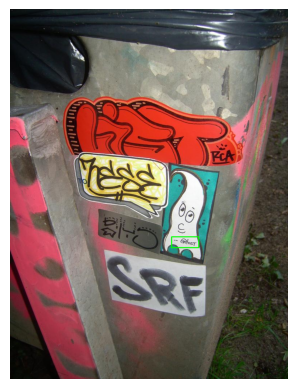

In [10]:
# 先读取一个图片然后观察坐标
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

EXAMPLE_IMAGE_PATH = "./data/test/003001.jpg"
EXAMPLE_TEXT_PATH = "./data/test.jsonl"

# 读取 JSONL 文件并查找符合条件的数据
def find_data_with_image_path(file_path, image_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                data = json.loads(line)  # 解析每一行的 JSON 数据
                # 检查是否存在键 "image" 且其值是一个列表，且列表的第一个元素是 EXAMPLE_IMAGE_PATH
                if 'image' in data and isinstance(data['image'], list) and data['image'][0] == image_path:
                    return data
            except json.JSONDecodeError as e:
                print(f"解析 JSON 时出错: {e}")
                continue
    return None

# 调用函数并输出结果
result = find_data_with_image_path(EXAMPLE_TEXT_PATH, EXAMPLE_IMAGE_PATH)
if result:
    print("找到符合条件的数据：")
    print(json.dumps(result, indent=4, ensure_ascii=False))
else:
    print("未找到符合条件的数据。")

print("-"*20)
## 找到对应的数据了后，画在图上
bboxes = result['response']
# 转换成json格式
bboxes_dict = json.loads(bboxes)
bboxes = bboxes_dict['bbox_2d']

# 读取图像，然后看看图像的大小和坐标的对应关系
image = cv2.imread(EXAMPLE_IMAGE_PATH)
print(f"图像大小是{image.shape}")
print(f"坐标是{bboxes}")

### 所以坐标的话应该是[左上角x, 左上角y, 宽度, 高度]
x1, y1, x2, y2 = [446, 630, 521, 660]
cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
## 缩放图了之后观察坐标值和图像的对应关系
import math

# This is the resize function of Qwen2.5-VL
def smart_resize(
    height: int, width: int, factor: int = 28, min_pixels: int = 56 * 56, max_pixels: int = 14 * 14 * 4 * 1280
):
    """Rescales the image so that the following conditions are met:
    1. Both dimensions (height and width) are divisible by 'factor'.
    2. The total number of pixels is within the range ['min_pixels', 'max_pixels'].
    3. The aspect ratio of the image is maintained as closely as possible.
    """
    if height < factor or width < factor:
        raise ValueError(f"height:{height} or width:{width} must be larger than factor:{factor}")
    elif max(height, width) / min(height, width) > 200:
        raise ValueError(
            f"absolute aspect ratio must be smaller than 200, got {max(height, width) / min(height, width)}"
        )
    h_bar = round(height / factor) * factor
    w_bar = round(width / factor) * factor
    if h_bar * w_bar > max_pixels:
        beta = math.sqrt((height * width) / max_pixels)
        h_bar = math.floor(height / beta / factor) * factor
        w_bar = math.floor(width / beta / factor) * factor
    elif h_bar * w_bar < min_pixels:
        beta = math.sqrt(min_pixels / (height * width))
        h_bar = math.ceil(height * beta / factor) * factor
        w_bar = math.ceil(width * beta / factor) * factor
    return h_bar, w_bar


def convert_to_qwen25vl_format(bbox, orig_height, orig_width, factor=28, min_pixels=56*56, max_pixels=14*14*4*1280):
    new_height, new_width = smart_resize(orig_height, orig_width, factor, min_pixels, max_pixels)
    scale_w = new_width / orig_width
    scale_h = new_height / orig_height
    
    x1, y1, x2, y2 = bbox
    x1_new = round(x1 * scale_w)
    y1_new = round(y1 * scale_h)
    x2_new = round(x2 * scale_w)
    y2_new = round(y2 * scale_h)
    
    x1_new = max(0, min(x1_new, new_width - 1))
    y1_new = max(0, min(y1_new, new_height - 1))
    x2_new = max(0, min(x2_new, new_width - 1))
    y2_new = max(0, min(y2_new, new_height - 1))
    
    return [x1_new, y1_new, x2_new, y2_new]


new_bboxes = [x1, y1, x1+w, y1+h]
print(f"新的坐标是{new_bboxes}")
print(f"转换后的坐标是{convert_to_qwen25vl_format(new_bboxes, image.shape[0], image.shape[1])}")


新的坐标是[959, 628, 1978, 1277]
转换后的坐标是[970, 623, 1035, 671]


In [9]:
def reverse_convert_to_original_format(bbox_new, orig_height, orig_width, new_height, new_width):
    """
    从修改后的坐标恢复原始坐标值。
    
    参数:
    - bbox_new: 修改后的边界框坐标 [x1_new, y1_new, x2_new, y2_new]
    - orig_height: 原始图像的高度
    - orig_width: 原始图像的宽度
    - new_height: 修改后的图像高度
    - new_width: 修改后的图像宽度
    
    返回:
    - 原始坐标 [x1, y1, x2, y2]
    """
    scale_w = new_width / orig_width
    scale_h = new_height / orig_height
    
    x1_new, y1_new, x2_new, y2_new = bbox_new
    
    # 反向计算原始坐标
    x1 = round(x1_new / scale_w)
    y1 = round(y1_new / scale_h)
    x2 = round(x2_new / scale_w)
    y2 = round(y2_new / scale_h)
    
    # 确保原始坐标在原始图像范围内
    x1 = max(0, min(x1, orig_width - 1))
    y1 = max(0, min(y1, orig_height - 1))
    x2 = max(0, min(x2, orig_width - 1))
    y2 = max(0, min(y2, orig_height - 1))
    
    return [x1, y1, x2, y2]

# 示例使用
orig_height = image.shape[0]
orig_width = image.shape[1]

# 获取新的图像尺寸
new_height, new_width = smart_resize(orig_height, orig_width)
bbox=[x1, y1, x2, y2]
# 恢复原始坐标
original_bbox = reverse_convert_to_original_format(bbox, orig_height, orig_width, new_height, new_width)
print("原始坐标:", original_bbox)

原始坐标: [656, 437, 770, 507]
